 # <font color="#114b98">      <div align="center">  Développez une preuve de concept

Dans ce projet, on s'intéresse à mettre en oeuvre d'un approche récente pour un problème concret de data science et le comparer avec une apprcohe déja utilisée pour le même problème comme une méthode de baseline.
Nous avons choisi la segmentation d'images, en particulier des images sous-marines  

Dans un notebook précédent nous entrainer le modèle Unet pour la tâche de la segmentation d'images sous-marines. Dans ce notebook nous allons considérer les mêmes images afin d'entrainer le modèle SegFormer. Nous allons utiliser un
modèle prentrainé de Hugging Face! entrainé sur des données contenant des catégories proches de celles de nos images sous-marines 

Tous les Notebooks et un rapport du projet seront versionnés dans un repositoire GitHub disponible à l'adresse: https://github.com/Bounkass/Projet_7PoC

## <font color="#ea1c60">Sommaire</font>  
[1. Chargement et préparation des images](#section_1)

[2. Modèle SegFormer avec finetunning méthode](#section_2)

[3. Inférence sur des données test ](#section_3) 

Installation des transformeurs et du module de datasets de Hugging Face

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 36.3 MB/s 
     |████████████████████████████████| 7.6 MB 57.7 MB/s 
     |████████████████████████████████| 163 kB 71.7 MB/s 


In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 31.0 MB/s 
     |████████████████████████████████| 115 kB 69.6 MB/s 
     |████████████████████████████████| 212 kB 74.3 MB/s 
     |████████████████████████████████| 127 kB 74.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
# import  python librairies
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from pathlib import Path
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from torchvision.transforms import functional as TF
import pandas as pd
import cv2
import numpy as np
import time

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#path = "C:/Users/moumouni/Desktop/projet6/Images"
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/P7_poc.zip"

with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Done!')

Done!


### <font id="section_1">1. Chargement et prépaaration des images

Nous allons utiliser deux primitives de données : torch.utils.data.DataLoader et torch.utils.data.Dataset qui nous permettent d'utiliser et  chargés nos données au fur et à mesure de l'entrainement du modèle.

In [6]:
class SUIM(Dataset):
    classes = ['water', 'human divers', 'aquatic plants & sea-grass', 'wrecks & ruins', 'robots', 'reefs & invertebrates', 'fish & vertebrates', 'sea-floor & rocks']
    Palette = torch.tensor([[0, 0, 0], [0, 0, 255], [0, 255, 0], [0, 255, 255], [255, 0, 0], [255, 0, 255], [255, 255, 0], [255, 255, 255]])
    
    def __init__(self, root: str, split: str = 'train', transform = None):
        super().__init__()
        assert split in ['train', 'test']
        self.split = 'train_val' if split == 'train' else 'TEST'
        self.transform = transform
        self.n_classes = len(self.classes)
        self.ignore_label = 255    

        img_path = Path(root) / self.split / 'images'
        self.files = list(img_path.glob("*.jpg"))
    
        if not self.files:
            raise Exception(f"No images found in {img_path}")
        print(f"Found {len(self.files)} {split} images.")

    def __len__(self) -> int:
        return len(self.files)
    
    def __getitem__(self, index: int):
        img_path = str(self.files[index])
        lbl_path = str(self.files[index]).replace('images', 'masks').replace('.jpg', '.bmp')

        image = Image.open(img_path)
        image = TF.pil_to_tensor(image.resize((228,228), Image.ANTIALIAS))
        label = Image.open(lbl_path).convert('RGB')
        label = TF.pil_to_tensor(label.resize((228,228), Image.ANTIALIAS))


        if self.transform:
            image, label = self.transform(image, label)
        return image*1.0, self.encode(label).long()

    def encode(self, label):
        label = label.permute(1, 2, 0)
        mask = torch.zeros(label.shape[:-1])

        for index, color in enumerate(self.Palette):
            bool_mask = torch.eq(label, color)
            class_map = torch.all(bool_mask, dim=-1)
            mask[class_map] = index
        return mask

In [7]:
dir = '/content'
batch_size = 32
# read and loading all data
dataset = SUIM(dir,'train')
# split data on train and valid data
train_data, val_data = torch.utils.data.random_split(
    dataset,
    [1220, 305],
    generator=torch.Generator().manual_seed(42)
    )
# 
#Preparing  data for training with DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(val_data, batch_size=batch_size,
                          shuffle=False, num_workers=2,
                          drop_last=False)

Found 1525 train images.


## <font id="section_2">2. Modèle SegFormer avec finetunning méthode

Nous allons redéfinir les classes de notre dataset en leur attribuant des noms  des classes des données ADE20K sur lequelles le modèle chargé SegForm est preentrainé. Par exemple, nous remplaçons la classe "poisson"" par animal, la classe "robot" n'est pas définie pour les données ADE20K, nous l'assimilons à une la classe "box". 

In [8]:
classes = ['water', 'person', 'plants-grass', 'wrecks-ruins', 'box', 'reefs-invertebrates', 'animal', 'sea-floor-rocks']
label_to_id = {v: k for k, v in enumerate(classes)}
id_to_label = {v: k for k, v in label_to_id.items()}

Ici, nous chargeons le modèle SegFormer depuis huggingface où l'encodeur et équipé avec des poids pré-formés sur ImageNet-1k, nous prenons la plus petite variante, nvidia/mit-b0.
.

In [9]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=8, 
                                                         id2label=id_to_label, 
                                                         label2id=label_to_id,)

Downloading:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.bias', 'decode_head.batch_norm.running_mean', 'decode_head.line

#### Fine-tune le modèle

Ici, nous affinons le modèle dans PyTorch en utilisant l'optimiseur AdamW. Nous utilisons le même taux d'apprentissage que celui rapporté dans l'article détaillons le modèle SegFormer. Nous considérons les métriques typiques mIoU  (intersection moyenne sur l'union) et la précision au niveau des pixels. Nous pouvons le charger comme suit depuis la bibliothèque datasets:

In [18]:
from datasets import load_metric

# load metrics for train & validation data 
metric_train = load_metric("mean_iou")
metric_valid = load_metric("mean_iou")
metric_test = load_metric("mean_iou")
# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [ ]:
train_loss= []
train_acc = []
train_iou = []
val_loss = []
val_acc = []
val_iou = []
shape = (228,228)
epochs = 20
time1 = time.time()
for epoch in range(epochs):
    print("Epoch:", epoch+1)
    print('-'*30, 'Training', '-'*30)
    model.train()
    for idx, batch in enumerate(tqdm(train_loader, leave=False)):
     

        optimizer.zero_grad()

        outputs = model(pixel_values= batch[0].to(device), labels=batch[1].to(device))
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=shape, mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
          

            metric_train.add_batch(predictions=predicted.detach().cpu().numpy(), references=batch[1].to(device).detach().cpu().numpy())


        if idx % 100 == 0:
           metrics = metric_train.compute(num_labels=len(id_to_label), 
                                           ignore_index=255,
                                           reduce_labels=False,)

           print("Loss:", loss.item())
           print("Mean_iou:", metrics["mean_iou"])
           print("Mean accuracy:", metrics["mean_accuracy"])
           print('-'*50)
    train_loss.append(loss.item()) 
    train_iou.append(metrics["mean_iou"])
    train_acc.append(metrics["mean_accuracy"])  

    model.eval()
    print('-'*30, 'Validation', '-'*30)
    for idx, batch in enumerate(tqdm(valid_loader, leave=False)):
        
        outputs = model(pixel_values=batch[0].to(device), labels=batch[1].to(device))
        loss, logits = outputs.loss, outputs.logits
        
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=shape, mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
          
            metric_valid.add_batch(predictions=predicted.detach().cpu().numpy(), references=batch[1].to(device).detach().cpu().numpy())

        if idx % 19 == 0:
            metrics1 = metric_valid.compute(num_labels=len(id_to_label), 
                                           ignore_index=255,
                                           reduce_labels=False,
          )

            print("Loss:", loss.item())
            print("Mean_iou:", metrics1["mean_iou"])
            print("Mean accuracy:", metrics1["mean_accuracy"])

    val_loss.append(loss.item()) 
    val_iou.append(metrics1["mean_iou"])
    val_acc.append(metrics1["mean_accuracy"])

print("Total time of training in min:", round((time.time()-time1)/60,2))

Epoch: 1
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 2.1711902618408203
Mean_iou: 0.032431377868668884
Mean accuracy: 0.10287563672266814
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 1.3273073434829712
Mean_iou: 0.23468987994881846
Mean accuracy: 0.3159954683960974
Epoch: 2
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 1.3155373334884644
Mean_iou: 0.1762999175527064
Mean accuracy: 0.2682323902369821
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 1.0825495719909668
Mean_iou: 0.21483539384882613
Mean accuracy: 0.2998191182443113
Epoch: 3
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 1.176140308380127
Mean_iou: 0.24954334589409968
Mean accuracy: 0.3402476801240163
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.9608010649681091
Mean_iou: 0.2659215484895498
Mean accuracy: 0.35709344617379846
Epoch: 4
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.9467620253562927
Mean_iou: 0.3023253008913197
Mean accuracy: 0.39907806482573405
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.8874934911727905
Mean_iou: 0.2934647382407158
Mean accuracy: 0.3834018785951503
Epoch: 5
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.8392055630683899
Mean_iou: 0.33491288189208246
Mean accuracy: 0.43539324288011383
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.8578120470046997
Mean_iou: 0.33529164857355453
Mean accuracy: 0.43030445702966
Epoch: 6
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.7193397283554077
Mean_iou: 0.36708767942159815
Mean accuracy: 0.4656980130673551
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.8539356589317322
Mean_iou: 0.35431549271265866
Mean accuracy: 0.44837147212590805
Epoch: 7
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.696171224117279
Mean_iou: 0.3939923431712274
Mean accuracy: 0.4945025776370083
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.7726402878761292
Mean_iou: 0.35090444349816263
Mean accuracy: 0.44114849934859585
Epoch: 8
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.6874825954437256
Mean_iou: 0.4186422057513657
Mean accuracy: 0.5176682587212525
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.7495606541633606
Mean_iou: 0.3905877900177081
Mean accuracy: 0.49832509315196094
Epoch: 9
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.691772997379303
Mean_iou: 0.441252142835066
Mean accuracy: 0.5404464512802323
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.7071740031242371
Mean_iou: 0.4001274690874623
Mean accuracy: 0.5096410414499559
Epoch: 10
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.6180785894393921
Mean_iou: 0.4584034923188389
Mean accuracy: 0.556220695285795
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.6818280220031738
Mean_iou: 0.4068421523641213
Mean accuracy: 0.5324924729362397
Epoch: 11
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.6078155040740967
Mean_iou: 0.47475834137127465
Mean accuracy: 0.5724166172364304
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.7043606638908386
Mean_iou: 0.4146092803279953
Mean accuracy: 0.5303401275534279
Epoch: 12
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.5946547389030457
Mean_iou: 0.483615406386946
Mean accuracy: 0.5808001559827207
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.6765055060386658
Mean_iou: 0.414670720993813
Mean accuracy: 0.5270888669188495
Epoch: 13
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.5765154957771301
Mean_iou: 0.4927205890416665
Mean accuracy: 0.5877975812994913
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.665627658367157
Mean_iou: 0.42441446403915073
Mean accuracy: 0.5422229981184654
Epoch: 14
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.46505334973335266
Mean_iou: 0.5046942337400284
Mean accuracy: 0.601717540807057
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.6700616478919983
Mean_iou: 0.4171598395333944
Mean accuracy: 0.5267972207115926
Epoch: 15
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.4833296835422516
Mean_iou: 0.515340392141129
Mean accuracy: 0.6097411128049846
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.7017685770988464
Mean_iou: 0.42690167436970494
Mean accuracy: 0.5445283954649598
Epoch: 16
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.49720850586891174
Mean_iou: 0.5278708309447637
Mean accuracy: 0.618701436380604
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.6520857810974121
Mean_iou: 0.42824420876824737
Mean accuracy: 0.5446873840507287
Epoch: 17
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.49854692816734314
Mean_iou: 0.5255875413806961
Mean accuracy: 0.6191450338407145
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.6698331236839294
Mean_iou: 0.43514096472418234
Mean accuracy: 0.5419722112376439
Epoch: 18
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.38196203112602234
Mean_iou: 0.5486130721263547
Mean accuracy: 0.6400754140664742
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.6493861079216003
Mean_iou: 0.4462904719042927
Mean accuracy: 0.5657219770008327
Epoch: 19
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.44136419892311096
Mean_iou: 0.5582405806974258
Mean accuracy: 0.6480261502427669
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.6436125636100769
Mean_iou: 0.4424280686970163
Mean accuracy: 0.5629019980539256
Epoch: 20
------------------------------ Training ------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 0.41504016518592834
Mean_iou: 0.5780124090976425
Mean accuracy: 0.6696141421673014
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Loss: 0.648763120174408
Mean_iou: 0.4517045516670275
Mean accuracy: 0.5682858161398106
Total time of training in min: 126.98


In [ ]:
path = "/content/drive/MyDrive/Saved_model/SegForm_iuwbis.pt"

# Save model
torch.save(model, path)

Visualisant les courbes des matriques considérées:

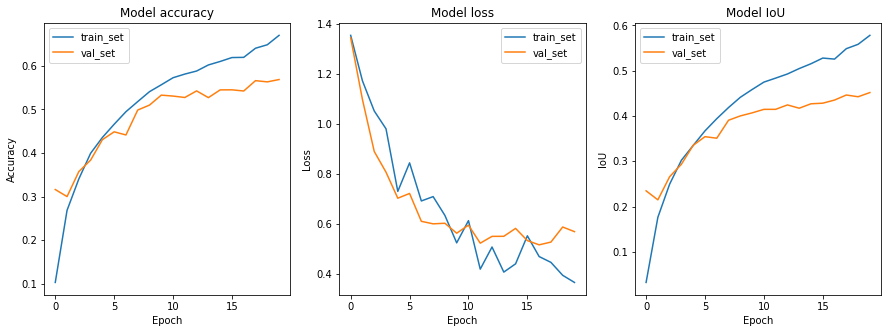

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# summarize history for accuracy
ax[0].plot(train_acc)
ax[0].plot(val_acc)
ax[0].set_title('Model accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train_set','val_set'])

# summarize history for loss
ax[1].plot(train_loss)
ax[1].plot(val_loss)
ax[1].set_title('Model loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['train_set','val_set'])

# summarize history for IoU
ax[2].plot(train_iou, label='train_set')
ax[2].plot(val_iou, label='val_set')
ax[2].set_title('Model IoU ')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('IoU')
ax[2].legend(['train_set','val_set'])
plt.show()

### <font id="section_3">3. Inférence sur des données test

Les métriques sont meilleurs que ceux données par le modèle Unet, Nos allons  visualisert des prédictions du modèle sur des images test.

In [11]:
#load model    
#model1 = torch.load("/content/drive/MyDrive/Saved_model/SegForm_iuw.pt")

In [26]:
test_dataset = SUIM(dir,'test')

test_loader = DataLoader(dataset, batch_size=64,
                          shuffle=False, num_workers=2)

for batch in test_loader:
    images, masks = batch[0], batch[1]
    outputs = model(pixel_values=batch[0].to(device), labels=batch[1].to(device))
        
    loss, logits = outputs[0], outputs[1]

    upsampled_logits = nn.functional.interpolate(
        logits, 
        size=masks.shape[-2:], 
        mode="bilinear", 
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
    masks = masks.cpu().numpy()                              

Found 110 test images.


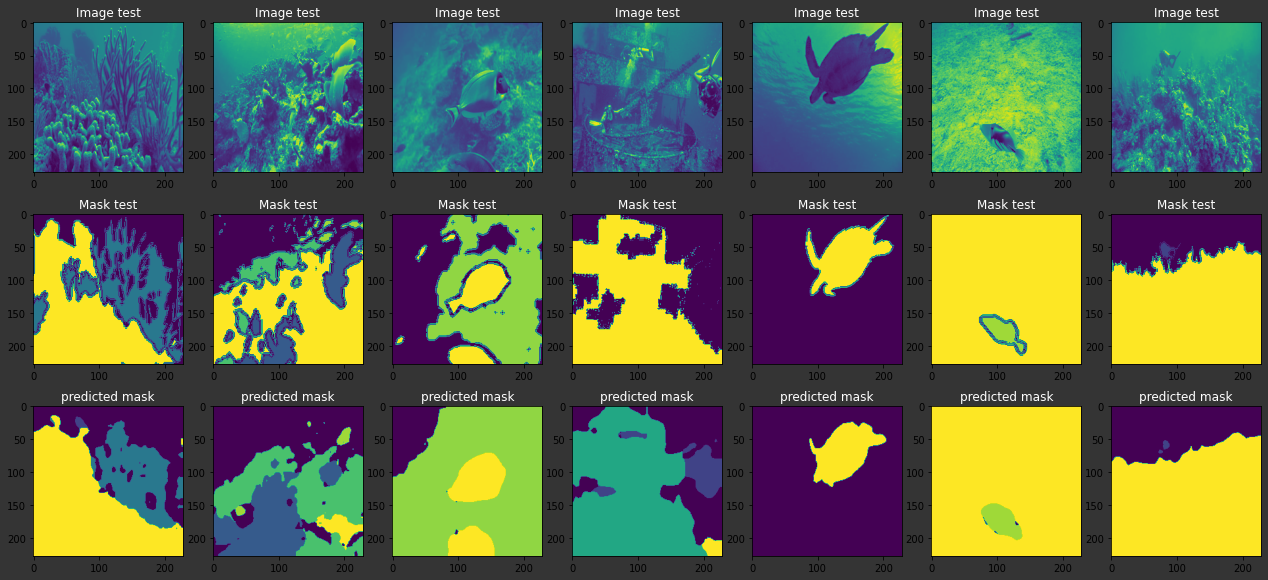

In [43]:
from torch.utils.data.dataloader import Sampler
n_plots = 7
m=10;
from matplotlib import pyplot as plt
f, ax = plt.subplots(3,n_plots)
f.set_figheight(10)
f.set_figwidth(22)
f.patch.set_facecolor('#343434')
for k in range(0,n_plots):
    ax[0,k].imshow((images[k+m,0,:,:]+images[k+m,1,:,:]+images[k+m,2,:,:])/3)
    ax[0,k].set_title("Image test",color="white")
    ax[2,k].imshow(predicted_mask[k+m,:,:])
    ax[2,k].set_title("predicted mask",color="white")
    ax[1,k].imshow(masks[k+m,:,:])
    ax[1,k].set_title("Mask test",color="white")

In [29]:
metrics = metric_test.compute(predictions=predicted_mask, references=masks, num_labels=8, ignore_index=255)
metric_table = dict()
for id, label in id_to_label.items():
    metric_table[label] = metrics["per_category_iou"][id]

print("Mean_iou:     ", metrics["mean_iou"])
print("Mean accuracy:", metrics["mean_accuracy"])
print('')
print("-"*30)
print(" per-category metrics:")
print("-"*30)

pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU"])



Mean_iou:      0.605530523695579
Mean accuracy: 0.7137343995274694

------------------------------
 per-category metrics:
------------------------------


,IoU
water,0.760330
person,0.518212
plants-grass,0.507251
wrecks-ruins,0.768283
box,0.093362
reefs-invertebrates,0.824704
animal,0.625970
sea-floor-rocks,0.746131
